In [51]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import folium
import csv
import io
import urllib.request
from datetime import datetime, timedelta
import numpy as np

In [2]:
# TODOS
# change attempt to 0-1
# check for missing values in estimated_values (9999?, 0)
# check for outliers
# Normalize or bin "estimated_values"

# Put bike types with too little obsevations together to "other"
#  What to do with "Fahrrad" bike type
# Encode categorical values

# Data Loading

In [3]:
url = "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"

download = requests.get(url)
decoded_content = download.content.decode('ISO-8859-1')
file = decoded_content.splitlines()

# cr = csv.reader(file, delimiter=',')
cr = csv.DictReader(file, delimiter=',')
my_list = list(cr)
df = pd.DataFrame(my_list)

In [4]:
df.head()

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND
0,28.02.2022,26.02.2022,14,26.02.2022,14,07100103,580,Nein,Fahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
1,28.02.2022,28.02.2022,16,28.02.2022,16,02100106,0,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
2,28.02.2022,28.02.2022,20,28.02.2022,20,08300935,0,Nein,diverse Fahrräder,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern
3,28.02.2022,28.02.2022,08,28.02.2022,08,04400727,1000,Nein,diverse Fahrräder,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4,28.02.2022,25.02.2022,05,25.02.2022,17,09100305,499,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


# Data Cleaning of the Bike Theft dataset

Cleaning steps: 
- Translation
- Duplicates
- Missing values
- outliers
- scaling
- balancing

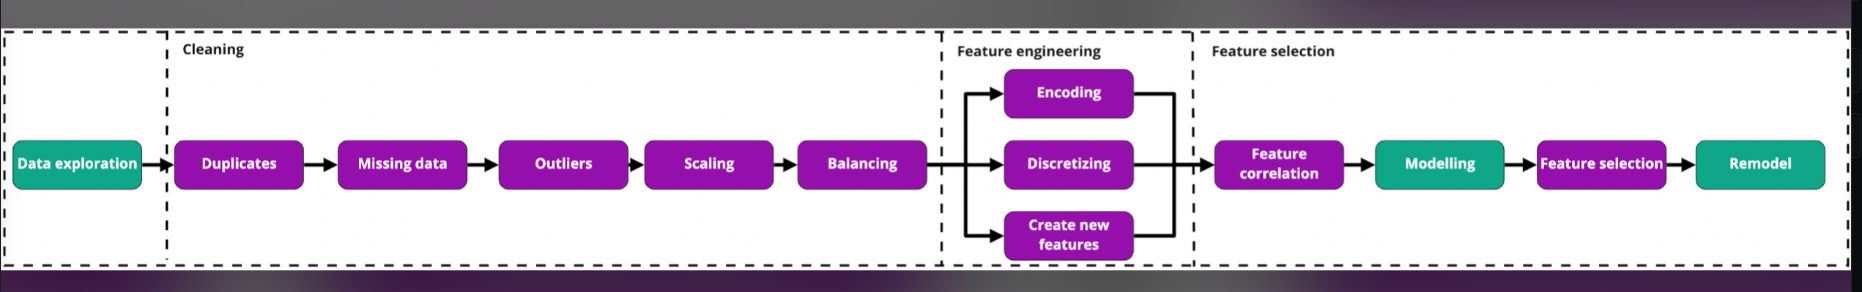

## Translation

### Translate column names

In [5]:
df.columns

Index(['ANGELEGT_AM', 'TATZEIT_ANFANG_DATUM', 'TATZEIT_ANFANG_STUNDE',
       'TATZEIT_ENDE_DATUM', 'TATZEIT_ENDE_STUNDE', 'LOR', 'SCHADENSHOEHE',
       'VERSUCH', 'ART_DES_FAHRRADS', 'DELIKT', 'ERFASSUNGSGRUND'],
      dtype='object')

In [6]:
eng_col_names = {
    "ANGELEGT_AM": "date_reported",
    "TATZEIT_ANFANG_DATUM": "date_theft_start",
    "TATZEIT_ANFANG_STUNDE": "hour_theft_start",
    "TATZEIT_ENDE_DATUM": "date_theft_end",
    "TATZEIT_ENDE_STUNDE": "hour_theft_end",
    "LOR": "LOR",
    "SCHADENSHOEHE": "estimated_value",
    "VERSUCH": "attempt",
    "ART_DES_FAHRRADS": "type_bike", 
    "DELIKT": "theft_type",
    "ERFASSUNGSGRUND": "theft_type_detail"    
}

In [7]:
df.rename(columns= eng_col_names, inplace=True)

In [8]:
df.columns

Index(['date_reported', 'date_theft_start', 'hour_theft_start',
       'date_theft_end', 'hour_theft_end', 'LOR', 'estimated_value', 'attempt',
       'type_bike', 'theft_type', 'theft_type_detail'],
      dtype='object')

### Translate categories

In [9]:
# pd.DataFrame(df[["type_bike", "attempt", "theft_type", "theft_type_detail"]].value_counts())

#### Type_bike

In [10]:
df["type_bike"].value_counts().keys()

Index(['Herrenfahrrad', 'Damenfahrrad', 'Fahrrad', 'Mountainbike',
       'Kinderfahrrad', 'diverse Fahrräder', 'Rennrad', 'Lastenfahrrad'],
      dtype='object')

In [11]:
# define function for renaming the categories
def rename_type_bike(x): 
    if x == "Herrenfahrrad": 
        return "man's bike"
    if x == "Damenfahrrad":
        return "woman's bike"
    if x == "Fahrrad":
        return "bike"
    if x == "Kinderfahrrad":
        return "child's bike"
    else: 
        return "other bike"

In [12]:
df["type_bike"] = df["type_bike"].apply(rename_type_bike)

In [13]:
df["type_bike"].value_counts()

man's bike      10133
woman's bike     6488
bike             2664
other bike       1800
child's bike      842
Name: type_bike, dtype: int64

#### attempt

In [14]:
df["attempt"].value_counts()

Nein         21833
Ja              85
Unbekannt        9
Name: attempt, dtype: int64

In [15]:
attempt_dict = {
    "Ja": "Yes", 
    "Nein": "No", 
    "Unbekannt": "Unknown"
}

In [16]:
# change "yes"/"no"/"unknown" to 0/1/"unknown"
df["attempt"] = df["attempt"].map(attempt_dict)

In [17]:
df["attempt"].value_counts()

No         21833
Yes           85
Unknown        9
Name: attempt, dtype: int64

#### Theft type and theft type detail

In [18]:
# Leaving in German for now

## Change dtypes

In [19]:
# convert the date columns
df["date_reported"] = pd.to_datetime(df["date_reported"], format='%d.%m.%Y')
df["date_theft_start"] = pd.to_datetime(df["date_theft_start"], format='%d.%m.%Y')
df["date_theft_end"] = pd.to_datetime(df["date_theft_end"], format='%d.%m.%Y')

# convert the time columns 
df["hour_theft_start"] = df["hour_theft_start"].astype(int)
df["hour_theft_end"] = df["hour_theft_end"].astype(int)


df.dtypes

date_reported        datetime64[ns]
date_theft_start     datetime64[ns]
hour_theft_start              int64
date_theft_end       datetime64[ns]
hour_theft_end                int64
LOR                          object
estimated_value              object
attempt                      object
type_bike                    object
theft_type                   object
theft_type_detail            object
dtype: object

In [20]:
df["estimated_value"] = df["estimated_value"].astype(float)

In [21]:
df.dtypes

date_reported        datetime64[ns]
date_theft_start     datetime64[ns]
hour_theft_start              int64
date_theft_end       datetime64[ns]
hour_theft_end                int64
LOR                          object
estimated_value             float64
attempt                      object
type_bike                    object
theft_type                   object
theft_type_detail            object
dtype: object

## Duplicates

In [22]:
df.duplicated().sum()

36

In [23]:
df = df.drop_duplicates()

## Missing data

In [24]:
df.isna().sum()

date_reported        0
date_theft_start     0
hour_theft_start     0
date_theft_end       0
hour_theft_end       0
LOR                  0
estimated_value      0
attempt              0
type_bike            0
theft_type           0
theft_type_detail    0
dtype: int64

In [25]:
df.dtypes

date_reported        datetime64[ns]
date_theft_start     datetime64[ns]
hour_theft_start              int64
date_theft_end       datetime64[ns]
hour_theft_end                int64
LOR                          object
estimated_value             float64
attempt                      object
type_bike                    object
theft_type                   object
theft_type_detail            object
dtype: object

In [26]:
# check min and max for date and time columns
for col in list(df.columns[:5]):
    #print(col)
    print(f"min of {col}:  {df[col].min()}")
    print(f"max of {col}:  {df[col].max()}")

min of date_reported:  2021-01-01 00:00:00
max of date_reported:  2022-02-28 00:00:00
min of date_theft_start:  2021-01-01 00:00:00
max of date_theft_start:  2022-02-28 00:00:00
min of hour_theft_start:  0
max of hour_theft_start:  23
min of date_theft_end:  2021-01-01 00:00:00
max of date_theft_end:  2022-02-28 00:00:00
min of hour_theft_end:  0
max of hour_theft_end:  23


In [27]:
# check distribution of numerical variables 
df.describe()

,hour_theft_start,hour_theft_end,estimated_value
count,21891.000000,21891.000000,21891.000000
mean,14.518021,13.332328,904.661779
std,5.310065,5.248086,867.188373
min,0.000000,0.000000,0.000000
25%,10.000000,9.000000,400.000000
50%,16.000000,14.000000,649.000000
75%,19.000000,17.000000,1050.000000
max,23.000000,23.000000,9999.000000


### Estimated Value

Conclusion:  
- We have some bikes with "9999" as estimated value. These seem to be reasonable observations, that we'll keep
- We also have some bikes with "0" estimated value. These include both attempts and actually stolen bikes. 

--> Since we won't use estimated value for the first model, we will won't impute the "0" estimated value observations

In [28]:
df["estimated_value"].mode()

0    500.0
Name: estimated_value, dtype: float64

In [29]:
df["estimated_value"].sort_values(ascending= False).head(20)

1193     9999.0
4714     9999.0
2665     9559.0
13935    9500.0
3347     9420.0
10173    9000.0
9147     8450.0
10553    8449.0
20814    8400.0
20010    8027.0
18532    8000.0
7439     8000.0
20607    7999.0
2776     7990.0
9009     7899.0
6066     7871.0
5902     7798.0
4859     7700.0
9933     7500.0
21104    7500.0
Name: estimated_value, dtype: float64

In [30]:
df.sort_values(by = "estimated_value", ascending= False).head()

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail
1193,2022-02-03,2022-02-03,16,2022-02-03,16,11300722,9999.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4714,2021-11-16,2021-11-16,10,2021-11-16,11,11300723,9999.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
2665,2021-12-29,2021-12-26,19,2021-12-29,15,09501737,9559.0,No,man's bike,Keller- und Bodeneinbruch,Sonstiger schwerer Diebstahl in/aus Keller/Bod...
13935,2021-07-04,2021-07-04,16,2021-07-04,17,02400623,9500.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
3347,2021-12-12,2021-12-11,19,2021-12-12,18,03601140,9420.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [31]:
# Estimated value: values of "9999" seem reasonable. Could be the case that the one can only enter 4 digits

In [32]:
# check "0" values for estimated value
df.sort_values(by = "estimated_value", ascending= True).head(20)

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail
478,2022-02-18,2022-02-18,1,2022-02-18,1,09502043,0.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
16175,2021-05-29,2021-05-29,12,2021-05-29,15,06100103,0.0,Yes,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
174,2022-02-24,2022-02-24,10,2022-02-24,11,02100104,0.0,No,other bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
21225,2021-01-26,2021-01-26,15,2021-01-26,15,03500935,0.0,Yes,man's bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern
178,2022-02-24,2022-02-24,14,2022-02-24,16,03200206,0.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
15864,2021-06-03,2021-06-03,6,2021-06-03,14,06200422,0.0,Yes,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
7488,2021-10-06,2021-10-06,21,2021-10-06,21,01100310,0.0,No,other bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
183,2022-02-24,2022-02-24,9,2022-02-24,10,07200411,0.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
184,2022-02-24,2022-02-24,12,2022-02-24,14,01100415,0.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
8760,2021-09-19,2021-09-18,15,2021-09-18,21,08100415,0.0,Yes,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [33]:
df[df["estimated_value"]==0].count()

date_reported        144
date_theft_start     144
hour_theft_start     144
date_theft_end       144
hour_theft_end       144
LOR                  144
estimated_value      144
attempt              144
type_bike            144
theft_type           144
theft_type_detail    144
dtype: int64

## Outliers

## Scaling


There is only one numerical variable (estimated value) that we could scale. As we don't use them right now, we can skip the scaling for now. 

# Feature Engineering

## Concat date and time

In [34]:
# add minute and seconds to hour column 
df["hour_theft_start"] = df["hour_theft_start"].astype(str) + ":00:00"

In [35]:
df["hour_theft_end"]  = df["hour_theft_end"].astype(str) + ":00:00"

In [36]:
df["datetime_theft_start"] = df["date_theft_start"].astype(str) + " " + df["hour_theft_start"].astype(str)
df["datetime_theft_end"] = df["date_theft_end"].astype(str) + " " + df["hour_theft_end"].astype(str)

In [37]:
df["datetime_theft_start"] = pd.to_datetime(df["datetime_theft_start"]) 
df["datetime_theft_end"] = pd.to_datetime(df["datetime_theft_end"]) 

In [38]:
df.head()

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,datetime_theft_start,datetime_theft_end
0,2022-02-28,2022-02-26,14:00:00,2022-02-26,14:00:00,07100103,580.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-26 14:00:00,2022-02-26 14:00:00
1,2022-02-28,2022-02-28,16:00:00,2022-02-28,16:00:00,02100106,0.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 16:00:00,2022-02-28 16:00:00
2,2022-02-28,2022-02-28,20:00:00,2022-02-28,20:00:00,08300935,0.0,No,other bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern,2022-02-28 20:00:00,2022-02-28 20:00:00
3,2022-02-28,2022-02-28,8:00:00,2022-02-28,8:00:00,04400727,1000.0,No,other bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 08:00:00,2022-02-28 08:00:00
4,2022-02-28,2022-02-25,5:00:00,2022-02-25,17:00:00,09100305,499.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-25 05:00:00,2022-02-25 17:00:00


## Calculate time delta

In [39]:
df["Timedelta_theft_end_start"] = (df["datetime_theft_end"] - df["datetime_theft_start"]).astype('timedelta64[h]')

In [40]:
df.head()

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,datetime_theft_start,datetime_theft_end,Timedelta_theft_end_start
0,2022-02-28,2022-02-26,14:00:00,2022-02-26,14:00:00,07100103,580.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-26 14:00:00,2022-02-26 14:00:00,0.0
1,2022-02-28,2022-02-28,16:00:00,2022-02-28,16:00:00,02100106,0.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 16:00:00,2022-02-28 16:00:00,0.0
2,2022-02-28,2022-02-28,20:00:00,2022-02-28,20:00:00,08300935,0.0,No,other bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern,2022-02-28 20:00:00,2022-02-28 20:00:00,0.0
3,2022-02-28,2022-02-28,8:00:00,2022-02-28,8:00:00,04400727,1000.0,No,other bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 08:00:00,2022-02-28 08:00:00,0.0
4,2022-02-28,2022-02-25,5:00:00,2022-02-25,17:00:00,09100305,499.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-25 05:00:00,2022-02-25 17:00:00,12.0


<AxesSubplot:xlabel='Timedelta_theft_end_start', ylabel='estimated_value'>

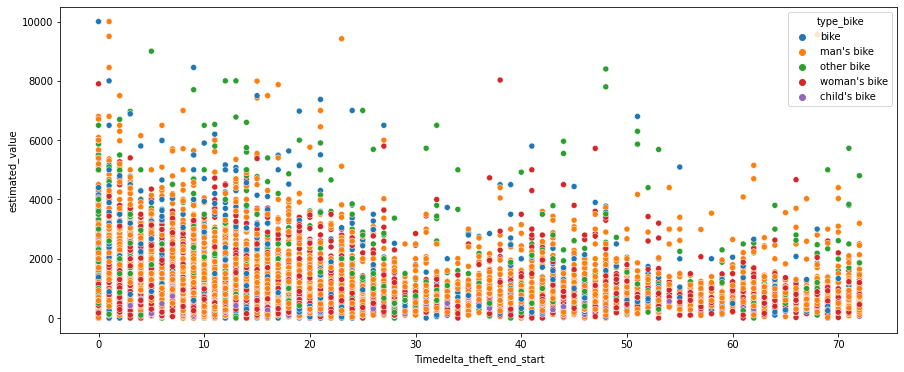

In [41]:
plt.figure(figsize = (15, 6))
sns.scatterplot(data = df, x = "Timedelta_theft_end_start", y = "estimated_value", hue ="type_bike")

<AxesSubplot:xlabel='Timedelta_theft_end_start', ylabel='Count'>

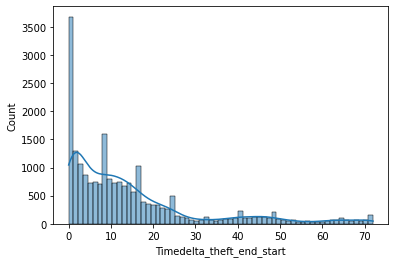

In [42]:
sns.histplot(x = df["Timedelta_theft_end_start"], kde = True)

In [43]:
df[df["Timedelta_theft_end_start"] == 0].count()

date_reported                2180
date_theft_start             2180
hour_theft_start             2180
date_theft_end               2180
hour_theft_end               2180
LOR                          2180
estimated_value              2180
attempt                      2180
type_bike                    2180
theft_type                   2180
theft_type_detail            2180
datetime_theft_start         2180
datetime_theft_end           2180
Timedelta_theft_end_start    2180
dtype: int64

In [44]:
# Conclusion: Timedelta between theft start and end doesn't give any meaningfull insights.
#  Caclulating whether the bike was stolen during the day or at night is not possible, as we have many timedeltas
#  > 24 hours. 

## Calculate mean between theft start and end

In [57]:
# We first have to convert the Timedelta column to datetime.timedelta and specify that it is only hours. 
# Then add the Timedelta divided by 2 to the datetime_theft_start

df["datetime_theft_mean"] = df["datetime_theft_start"] + (df["Timedelta_theft_end_start"].apply(lambda x: timedelta(hours = x)) /2 )

## Extracting higher levels from LOR

In [60]:
# BZR (first six numbers)
df["BZR"] = df["LOR"].str[:6]

In [61]:
# PGR (first four numbers)
df["PGR"] = df["LOR"].str[:4]

In [62]:
# Bezirk (first four numbers)
df["Bezirk"] = df["LOR"].str[:2]

# Save cleaned dataset

In [63]:
df.to_csv("../raw_data/bike_theft_cleaned.csv")